# Lecture 9: Numerical Optimization

## Golden Section Search

GSS is a derivative-free method for optimization of 1D functions.
Say we want to minimize $f(x)$. We start by picking a tripel

$$
[a_0, c_0, b_0]
$$

with $a_0 < c_0 < b_0$ and $f(a_0)>f(c_0)$ and $f(c_0) < f(b_0)$.
Then we successively subdivide the larger of the intervals by a factor $\gamma = 2/(1+\sqrt{5})$
(golden section), and find the new tripel with the same properties as the initial one.
This guarantees convergence to a minimum

In [1]:
using PyPlot
PyPlot.svg(true)

using Interact
using PyCall

using LinearAlgebra

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b259bc1dfe140ed8f0da8b1fc8d2e3ff788d8a11-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b259bc1dfe140ed8f0da8b1fc8d2e3ff788d8a11-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [2]:
function golden_section_search(f, a, b; tol=√eps())
    """ Golden Section Search from initial tripel [a, a + γ(b - a), b]
    """
    γ = 2.0/(1. + √(5.0))
    
    # probe points
    c = b - γ*(b - a)
    d = a + γ*(b - a)
    
    while abs(c - d) > tol
        if f(c) < f(d)
            b = d
        else
            a = c
        end
        
        c = b - γ*(b - a)
        d = a + γ*(b - a)
    end
    
    x = (a + b)/2
    return x, f(x)
end

golden_section_search (generic function with 1 method)

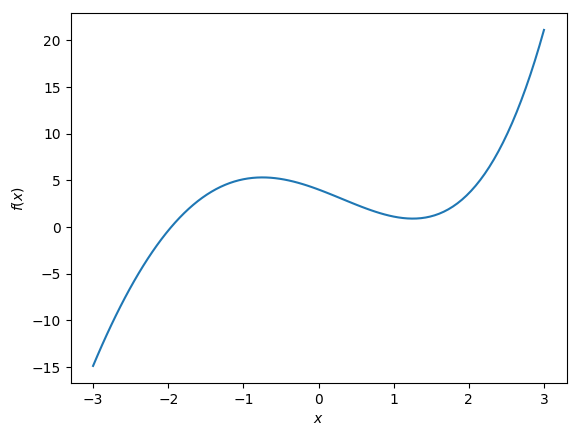

PyObject Text(26.000000000000007, 0.5, '$f(x)$')

In [3]:
f(x) = x^4/10 + x^3 - x^2 - 3x + 4

figure()
xs = LinRange(-3, 3, 100)
plot(xs, f.(xs))

xlabel(L"x")
ylabel(L"f(x)")

In [4]:
x_min, f_x_min = golden_section_search(f, 0.0, 3.0)

(1.2542263790915134, 0.8846995310827781)

In [5]:
# what happens when the initial bracket does not contain the minimum?
x_min, f_x_min = golden_section_search(f, -1.0, 0.5)

(0.4999999775350108, 2.381250071887966)

## Newton's Method

This is a method using derivatives. We apply Newton's root finding method
to the condition for a local extremum,

$$
f'(x) = 0
$$
in 1-D or
$$
\nabla f(\mathbf{x}) = 0
$$
in $n$-D.

In 1-D, Newton's method for finding local extrema then becomes
$$
x_{n+1} = x_n - \frac{f'(x_n)}{f''(x_n)},
$$

and in $n$-D, it becomes
$$
\mathbf{x}_{n+1} = \mathbf{x}_n - H^{-1}(\mathbf{x})\, \nabla f(\mathbf{x}),
$$
where $H(\mathbf{x})$ is the symmetric Hessian matrix of second derivatives,
$$
H_{ij} = \frac{\partial^2 f}{\partial x_i \partial x_j}.
$$

The advantage of Newton's method is quadratic convergence if the initial guess
is close to a true extremum, but if the initial guess is bad, it has the same 
convergence issues as its root-finding cousin.

In addition, it may be difficult to compute the Hessian matrix, and for large-scale
problems even to store it in memory.
That's why in practice, usually an approximative, "Quasi-Newton method" is used
instead.
Quasi-Newton methods approximate either $H$, $H^{-1}$, or even just the multiplication
$H^{-1}\nabla f$. The most widely used Quasi-Newton method is the
BFGS (Broyden–Fletcher–Goldfarb–Shanno) algorithm, which also has a variant with
particularly low memory footprint (L-BFGS).

In [6]:
# Newton's method for root finding
function newton_nd(f, J, x0; N=1000, ϵ=√eps())
    xs = [x0]
    
    for i=1:N
        # backslash operator solves linear system
        push!(xs, xs[end] .- (J(xs[end]) \ f(xs[end])))
        
        # convergence tolerance
        if norm(xs[end] - xs[end-1]) < ϵ*norm(xs[end])
            break
        end
    end
    
    return hcat(xs...)'
end

newton_nd (generic function with 1 method)

In [7]:
f(x) = x^4/10 + x^3 - x^2 - 3x + 4

# gradient condition of the function above
∇f(x) = (4.0/10)x^3 + 3x^2 - 2x - 3

# 1d "Hessian"
H(x) = (12.0/10)x^2 + 6x^2 - 2

newton_nd(∇f, H, 2.0)

15×1 Adjoint{Float64,Array{Float64,2}}:
 2.0               
 1.6940298507462688
 1.47081176668327  
 1.3366781436072346
 1.2775790118981445
 1.2595746908846532
 1.255353507229464 
 1.2544589386517446
 1.2542741473381263
 1.2542361852014885
 1.2542283954741411
 1.2542267974196555
 1.2542264695962813
 1.2542264023475735
 1.2542263885524025

In [8]:
# 2D version
# compute derivatives using automatic differentiation
using ReverseDiff

f(x) = 2*(x[1] - 1)^2*(x[2] + 3) + 3x[2]^3 + exp(-(x[1]*x[2])^2 - 2.0) - 1

∇f(x) = ReverseDiff.gradient(f, x)
H(x) = ReverseDiff.hessian(f, x)

H (generic function with 1 method)

In [10]:
# autodiff gradient

∇f([0.1; 0.2])

2-element Array{Float64,1}:
 -11.52108224927959  
   1.9794588753602054

In [12]:
# autodiff Hessian

H([0.1; 0.2])

2×2 Array{Float64,2}:
 12.7892   -3.61082
 -3.61082   3.5973 

In [13]:
x_min = newton_nd(∇f, H, [-0.5; -1.5])

13×2 Adjoint{Float64,Array{Float64,2}}:
 -0.5       -1.5        
  1.44459   -1.02053    
  0.909149  -0.528135   
  1.01145   -0.25739    
  0.999438  -0.121272   
  0.999981  -0.0538107  
  0.999986  -0.0210008  
  0.999996  -0.00611455 
  0.999999  -0.000883515
  1.0       -2.45129e-5 
  1.0       -1.99465e-8 
  1.0       -1.32287e-14
  1.0       -5.82022e-27

In [14]:
f(x_min[end,:])

-0.8646647167633873

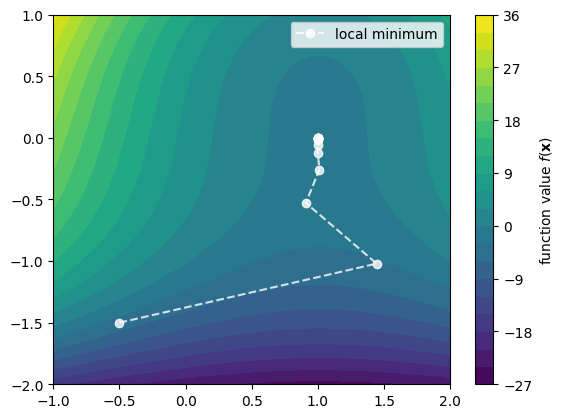

PyObject <matplotlib.legend.Legend object at 0x7f26ecf5ff98>

In [15]:
figure()

# grid on which we plot f(x)
n = 100
xs = LinRange(-1, 2, n)
ys = LinRange(-2, 1, n)

xgrid = repeat(xs', n, 1)
ygrid = repeat(ys, 1, n)

z = zeros(n, n)

for i in 1:n
    for j in 1:n
        z[i,j] = f([xgrid[i,j]; ygrid[i,j]])
    end
end

# Contour plot
contourf(xgrid, ygrid, z, 20)
plot(x_min[:,1], x_min[:,2], "wo--", alpha=.8, label="local minimum")

colorbar(label=L"function value $f(\mathbf{x})$")
legend()

## The Nelder-Mead method
The Nelder-Mead/downhill simplex/amoeba method is a derivative-free $n$-D optimization method.
The idea is to consider $n+1$ points forming a simplex in $n$-D and evaluate the function $f(\mathbf{x})$ on them.

At each step of the method, the following procedures are performed:

* Order the points $\mathbf{x}_1, \dots \mathbf{x}_{n+1}$ such that 
$$
f(\mathbf{x}_1) \leq f(\mathbf{x}_2) \leq \dots \leq f(\mathbf{x}_{n+1}).
$$

* Compute the centroid of the $n$ "best" (smallest function value) points
$$
\bar{\mathbf{x}} = \frac{1}{n}\sum_{i=1}^n \mathbf{x}_i
$$

We now want to construct a new simplex in which all function values are smaller
than for the current simplex.
This is done by constructing the reflection of the worst point $\mathbf{x}_{n+1}$
along the centroid
$$
\mathbf{x}(t) = \bar{\mathbf{x}} + t\,(\mathbf{x}_{n+1} -  \bar{\mathbf{x}}),
$$

with a particular choice of $t$ that makes the new point better (smaller function value).
Several things are tried, in order:

* Reflection: $\mathbf{x}(-1)$
    * If $f(\mathbf{x}_1) \leq f(\mathbf{x}(-1)) < f(\mathbf{x}_n)$, the reflected point is neither best nor
        worst.
        Replace $\mathbf{x}_{n-1}$ by $\mathbf{x}(-1)$ and repeat.
        
    * If $f(\mathbf{x}(-1)) < f(\mathbf{x}_1)$, The reflected point is
        better than the best, so try to go further in this direction.      
      * if $f(\mathbf{x}(-2)) < f(\mathbf{x}(-1))$, replace $\mathbf{x}_{n+1}$ by $\mathbf{x}(-2)$ and repeat
      * else, replace $\mathbf{x}_{n+1}$ by $\mathbf{x}(-1)$ and repeat
          
* Contraction: If $f(\mathbf{x}(-1)) \geq f(\mathbf{x}_n)$, reflected point is worse than the second-worst
    * If $f(\mathbf{x}_{n+1}) > f(\mathbf{x}(-1)) \geq f(\mathbf{x}_n)$: Between worst and second-worst,
        perform "outside contraction":
        if $f(\mathbf{x}(-1/2)) \geq f(\mathbf{x}(-1))$, replace $\mathbf{x}_{n+1}$
        by $\mathbf{x}(-1/2)$ and repeat
    * Else perform "inside contraction",  
        if $f(\mathbf{x}(1/2)) \geq f(\mathbf{x}_{n+1})$, replace $\mathbf{x}_{n+1}$
        by $\mathbf{x}(1/2)$ and repeat
        
* Shrinkage: If neither outside nor inside contraction were acceptable, give up
  and shrink the entire simplex $\mathbf{x}_i' = \frac{1}{2}(\mathbf{x}_1 + \mathbf{x}_i)$

In [17]:
# for the std function
using Statistics

function nelder_mead(f, simplex; N=100, tol=√eps())
    """ Implement the n-D Nelder-Mead algorithm.
    
    f should operate on n-D vectors,
    simplex should contain n+1 initial points.
    """
    f_simplexs = []
    simplices = []
    
    for i=1:N
        f_simplex = f.(simplex)
        
        # sort the function values and simplex corners
        Is = sortperm(f_simplex)
        f_simplex = f_simplex[Is]
        simplex = simplex[Is]
        
        push!(f_simplexs, [copy(f) for f in f_simplex])
        push!(simplices, [copy(s) for s in simplex])
        
        # termination criterion: variance of function values is small
        if std(f_simplex) < tol
            break
        end
        
        # centroid of n best values
        x_centroid = mean(simplex[1:end-1])
        
        # new value
        x(t) = x_centroid + t*(simplex[end] - x_centroid)
        
        # reflection
        x_ref = x(-1.0)
        f_ref = f(x_ref)
        
        if f_simplex[1] ≤ f_ref ≤ f_simplex[end-1]
            # not the best not the worst
            simplex[end] = x_ref
        elseif f_ref ≤ f_simplex[1]
            # better than the best, try to go further
            x_ref2 = x(-2.0)
            f_ref2 = f(x_ref2)
            
            if f_ref2 ≤ f_ref
                simplex[end] = x_ref2
            else
                simplex[end] = x_ref
            end
        elseif f_ref ≥ f_simplex[end-1]
            # reflected point is worse than second-worst, contract
            contraction_successful = false
            if f_simplex[end-1] ≤ f_ref < f_simplex[end]
                # outside contraction
                x_12 = x(-0.5)
                f_12 = f(x_12)
                if f_12 ≤ f_ref
                    simplex[end] = x_12
                    contraction_successful = true
                end
            else
                # inside contraction
                x_12 = x(0.5)
                f_12 = f(x_12)
                if f_12 < f_simplex[end]
                    simplex[end] = x_12
                    contraction_successful = true
                end
            end
            
            if !contraction_successful
                # give up and shrink entire simplex
                x1 = simplex[1]
                simplex = [0.5*(x - x1) for x in simplex]
            end
        end
    end
    
    return f_simplexs, simplices
end

nelder_mead (generic function with 1 method)

In [18]:
# Himmelblau function
f(x) = (x[1]^2 + x[2] - 11.0)^2 + (x[1] + x[2]^2 - 7.0)^2

simplex = [[1.0, 2.7], [-2.3, 5.0], [-1.5, -0.5]]

3-element Array{Array{Float64,1},1}:
 [1.0, 2.7]  
 [-2.3, 5.0] 
 [-1.5, -0.5]

In [19]:
f_simplexs, simplices = nelder_mead(f, simplex)

# solution is the *best* function value/simplex point
f_sol = f_simplexs[end][1]

9.038160853241748e-9

In [20]:
x_sol = simplices[end][1]

2-element Array{Float64,1}:
 3.0000005688987326
 2.000022710061454 

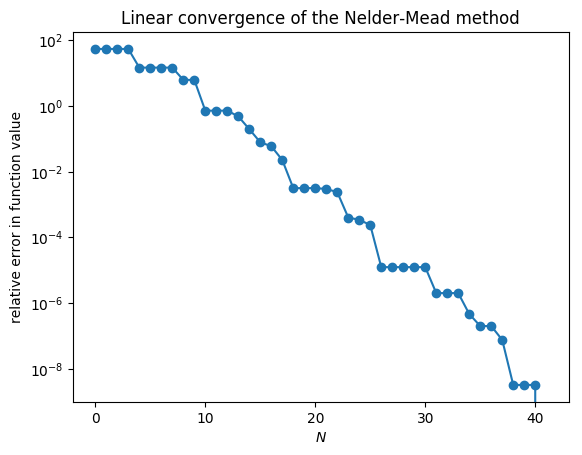

PyObject Text(0.5, 1.0, 'Linear convergence of the Nelder-Mead method')

In [21]:
# convergence of the best function value
f_bests = [f[1] for f in f_simplexs]

figure()

semilogy(abs.((f_bests .- f_bests[end])), "o-")

xlabel(L"N")
ylabel("relative error in function value")
title("Linear convergence of the Nelder-Mead method")

In [22]:
# for drawing simplices
patches = pyimport("matplotlib.patches")

PyObject <module 'matplotlib.patches' from '/home/henrik/.local/lib/python3.6/site-packages/matplotlib/patches.py'>

In [23]:
fig, ax = subplots()

# grid on which we plot f(x)
n = 100
xs = LinRange(-5, 5, n)
ys = LinRange(-5, 5, n)

xgrid = repeat(xs', n, 1)
ygrid = repeat(ys, 1, n)

z = zeros(n, n)

for i in 1:n
    for j in 1:n
        z[i,j] = f([xgrid[i,j]; ygrid[i,j]])
    end
end

# Contour plot
cb = ax.contourf(xgrid, ygrid, z, 60)
fig.colorbar(cb, label=L"function value $f(\mathbf{x})$")

ax.set_xlabel(L"x")
ax.set_ylabel(L"y")
ax.set_title("Convergence of the Nelder-Mead method")

@manipulate for i=slider(1:size(simplices)[1], value=1); withfig(fig, clear=false) do
        # remove old simplex
        for p in ax.patches
            p.remove()
        end
        
        s = simplices[i]
        patch = patches.Polygon(s, facecolor="none", edgecolor="white", linestyle="--", alpha=0.8, linewidth=2)
        ax.add_patch(patch)
        ax.plot()
    end
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:i=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
1), Observable{Int64} with 2 listeners. Value:
1, Scope("knockout-component-67d49481-17f3-4ba3-86e6-56c172d317e0", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any[nothing], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>42,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
1, nothing)), Set(String[]), nothing, Any["knockout"=>"/home/henrik/.julia/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/home/henrik/.julia/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/home/henrik/.julia/packages/InteractBase/PTCUD/src/../assets/all.js", "/home/henrik/.julia/packages/InteractBase/PTCUD/src/../assets/style.css", "/home/henrik/.julia/packages/InteractBulma/PH56C/src/../assets/main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":1}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-67d49481-17f3-4ba3-86e6-56c172d317e0\",\"id\":\"ob_02\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (WebIO.setval({\"name\":\"value\",\"scope\":\"knockout-component-67d49481-17f3-4ba3-86e6-56c172d317e0\",\"id\":\"ob_01\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"value\"]=false}),self)]\n        \n    }\n    self.model = new 